In [105]:
from fastai.text.all import *
import pandas as pd
cols = ["sentiment","text"]
df = pd.read_csv("data/all-data.csv", names =cols, encoding = "ISO-8859-1")
df_test = pd.read_csv("data/public-test-set.csv", names = cols, encoding = "ISO-8859-1")

In [106]:
#df['is_valid'] = False
#df_test['is_valid'] = True

In [107]:
df_all = pd.concat([df, df_test])

In [108]:
#helper functions:
def gen_sentence(preface_text):
    N_WORDS = 50
    N_SENTENCES = 2
    preds = [learn.predict(preface_text, n_words = N_WORDS, temperature=0.75) 
             for _ in range(N_SENTENCES)]
    return("\n\n".join(preds))

In [109]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

### Preproc

In [110]:
def clean_text(in_df):
    #Remove words which have numbers in them
    in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
    #Remove words which have special characters, except newline, space
    in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')
clean_text(df_test)
clean_text(df)
clean_text(df_all)

<ipython-input-110-084cba0ef93e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
<ipython-input-110-084cba0ef93e>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')


### Language Model

In [111]:
dls_lm = TextDataLoaders.from_df(df_all, is_lm=True, valid_pct=0.1, text_col='text')

In [112]:
learn = language_model_learner(dls_lm, AWD_LSTM, pretrained = True, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

In [113]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.847848,4.274235,0.260388,71.825157,00:10


In [114]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.330446,4.044360,0.295124,57.074631,00:11
1,4.157130,3.863593,0.315045,47.636208,00:12
2,3.962933,3.725284,0.332908,41.482998,00:11
3,3.770998,3.656935,0.341740,38.742405,00:12
4,3.604469,3.594521,0.351617,36.398254,00:12
5,3.469060,3.554686,0.357980,34.976830,00:11
6,3.343917,3.539632,0.361153,34.454239,00:11
7,3.246264,3.527908,0.364343,34.052666,00:12
8,3.197557,3.527126,0.364745,34.026039,00:11
9,3.152673,3.526618,0.364569,34.008747,00:11


In [115]:
learn.save_encoder('min_finetuned')

In [116]:
print(gen_sentence("The sales were"))

The sales were about EUR , . mn , a rise of EUR . mn from EUR . mn in through The transaction will bring the company 's total capital and life insurance business to St . Petersburg , Russia and St Petersburg

The sales were expected to be in and in the next few years . The company 's net sales in were EUR . million and it had net sales of million euros . The Dutch Royal Office of Public Sector said on


### Classifier

In [117]:
dls_clas = TextDataLoaders.from_df(df, valid_pct=0.4, text_col='text', label_col="sentiment", text_vocab=dls_lm.vocab)
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn = learn.load_encoder('min_finetuned')

In [118]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.889619,0.802976,0.613551,00:05


In [119]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.828816,0.733081,0.655458,00:05


In [120]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.741456,0.679534,0.700125,00:06


In [121]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.608840,0.664196,0.702886,00:07
1,0.558902,0.653208,0.712673,00:07


In [122]:
learn.save_encoder('min_finished')

### See results

In [123]:
print("Test Set Accuracy: ",learn.validate()[1]) #0.712

Test Set Accuracy:  0.7126725316047668


#### Train set

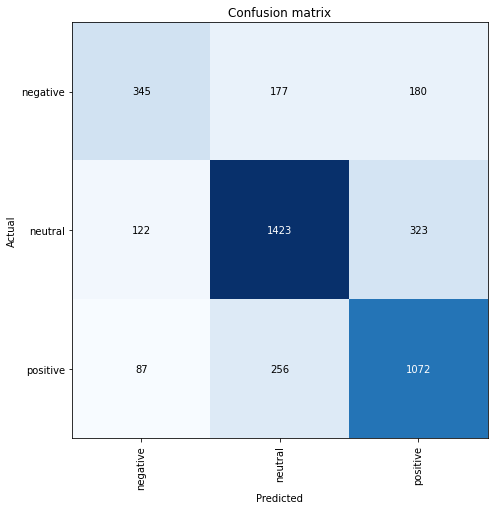

In [124]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(dls_clas.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

#### Test set

In [125]:
#data_test = TextDataLoaders.from_df(df_test, text_col='text', label_col="sentiment", text_vocab=dls_lm.vocab)
test_dl = learn.dls.test_dl(df_test)
preds, y = learn.get_preds()

In [126]:
dl_test = learn.dls.test_dl(df_test, with_labels=True, drop_last=False)
preds = learn.get_preds(dl=dl_test, with_decoded=True)
predictions = preds[2]
targets = preds[1]

In [127]:
#print(preds[2].shape)
#print(preds[1].shape)

In [128]:
def my_accuracy(y_pred, y_true):
    equ = [1 if i == t else 0 for i, t in zip(y_pred, y_true)]
    return np.mean(equ)

In [129]:
acc = my_accuracy(predictions, targets)
print("Test Set Accuracy: ",acc) #0.723

Test Set Accuracy:  0.7231340367330988


In [130]:
from sklearn.metrics import confusion_matrix
confusion_matrix(targets, predictions)

array([[ 620,  243,  266],
       [ 171, 1178,  383],
       [ 111,  243, 1903]])

In [131]:
#df_test.text

In [132]:
#Tried cleaning up data: via function clean_text, didn't improve a thing :(

In [133]:
#>>Done>> #Try other model instead of AWD_LSTM > AWD_QRNN. Didnt work. Pytorch error, too complicated fix.: https://forums.fast.ai/t/cant-import-qrnn-or-qrnnlayer/45072/7
#>>Done>> #Try make test set as validation set in classifier.
#See test accuracy change, after proper acc calc now, afte rreverting previous step
#check the other dataset for LM, not Reuters titles but perhaps better data for LM there